In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bagpipes as pipes
from PyAstronomy import pyasl
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

import sys
sys.path.append('../..')
# adds in additional chemical evolution models to bagpipes
from code_bits.add_ceh_funcs import *
# adds in additional GP noise kernels to bagpipes
from code_bits.add_GP_SHOTerm import *

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


### Before running any fits
In the bagpipes folder in site-packages, there is a `config.py` file. There are two main things that maybe best changed:
- `R_spec`: The spectral sampling rate when constructing composite stellar populations from the simple stellar population models. The higher this number, the higher the sampled resolution. For MaNGA, we worked out it should be at least 4340
- `max_redshift`: The maximum redshift bagpipes would calculate models for up to. If you are sure your galaxies are not higher than a certain redshift, this can be lowered to save time.

### First, create a mock PSB with a two-step metallicity
`metallicity_type` specifies the time-dependent metallicity evolutionary model of the SFH component. Currently implemented are:
   - `constant`: constant metallicity across time
   - `two_step`: a step function with the time of change as a free variable
   - `psb_two_step`: same as above but the time of change is fixed at burstage of the SFH model
   - `linear_step`: replacing the older step with a linear metallicity evolution, requires two new parameters: `metallicity_zero` (metallicity of the linear period if extended to intercept at 0 lookback time) and `metallicity_slope` (slope of the linear period, Zsun per Gyr)
   - `psb_linear_step`: same as above but the time of change is fixed at burstage of the SFH model

After specifying the evolutionary model, the metallicity distribution of stars of the same age can also be specified using `metallicity_scatter`. Currently implemented are:
   - `delta`: all stars have the same metallicity
   - `exp`: exponential distribution
   - `lognorm`: log normal distribution with sigma fixed at 0.45
If no scatter is given, it is assumed to be `delta`.

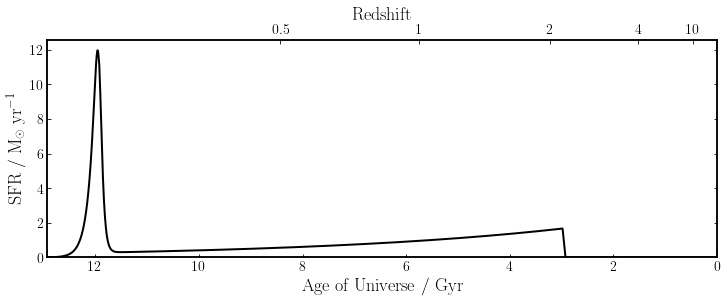

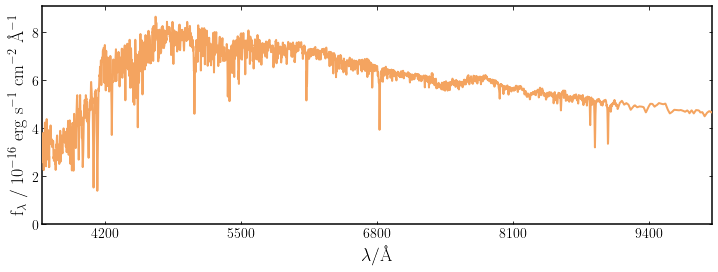

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [2]:
# refer to bagpipes documentation https://bagpipes.readthedocs.io/en/latest/model_components.html
# the SFH history dictionary
psb = {}
psb['massformed'] = 10
psb['age'] = 10
psb['tau'] = 5
psb['burstage'] = 1
psb['alpha'] = 100
psb['beta'] = 250
psb['fburst'] = 0.3

# metallicity portion
psb['metallicity_type'] = 'psb_two_step'
psb['metallicity_old'] = 1.0        # in Z*/Zsun
psb['metallicity_burst'] = 2.0      # in Z*/Zsun
psb['metallicity_scatter'] = 'delta'

# the model_component dictionary
model_comp = {}
model_comp['psb_wild2020'] = psb
model_comp['redshift'] = 0.04
# you can add other stuff here, e.g. dust, nebular emission, velocity dispersion, etc

obs_wavs = np.linspace(3600,10000, 5000)

mock_galaxy = pipes.model_galaxy(model_comp, spec_wavs=obs_wavs)
mock_galaxy.sfh.plot()
mock_galaxy.plot()

In [ ]:
# refer to bagpipes documentation https://bagpipes.readthedocs.io/en/latest/model_components.html
# the SFH history dictionary
psb = {}
psb['massformed'] = 10
psb['age'] = 10
psb['tau'] = 5
psb['burstage'] = 1
psb['alpha'] = 100
psb['beta'] = 250
psb['fburst'] = 0.3
psb['metallicity'] = 1.0

# the model_component dictionary
model_comp = {}
model_comp['psb_wild2020'] = psb
model_comp['redshift'] = 0.04
# you can add other stuff here, e.g. dust, nebular emission, velocity dispersion, etc

obs_wavs = np.linspace(3600,10000, 5000)

mock_galaxy = pipes.model_galaxy(model_comp, spec_wavs=obs_wavs)
mock_galaxy.sfh.plot()
mock_galaxy.plot()

# Fitting the mock spectrum

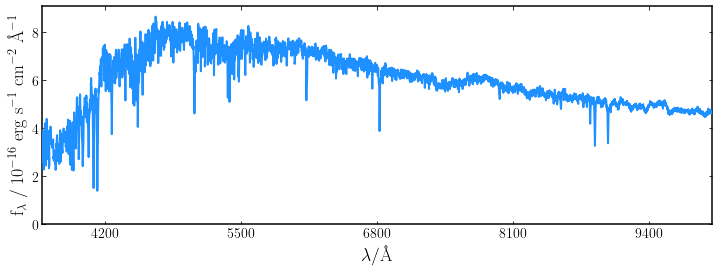

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [4]:
# Bagpipes requires a use-defined function that returns the spectrum in 3 columns:
# col0: wavelength in AA
# col1: flux in erg/s/cm^2/AA
# col2: noise in erg/s/cm^2/AA
# the function must also be passed a galaxy ID, used for fitting. 
# But in this case, we are not loading from file so it is not needed
def load_mock_spec(ID):
    SNR = 100
    noise = mock_galaxy.spectrum[:,1]/SNR
    # Perturb the spectrum with random Gaussian uncorrelated noise
    flux = mock_galaxy.spectrum[:,1]+np.random.randn(len(mock_galaxy.spectrum[:,1]))*noise
    spectrum = np.vstack([mock_galaxy.spectrum[:,0], flux, noise]).T
    return spectrum

# galID: galaxy ID is the name of the object you are currently fitting.
# It will also act as the name of the posterior and figure files in bagpipes' file structure
galID = 'mock_psb_twostep_SNR100'
galaxy = pipes.galaxy(galID, load_mock_spec, photometry_exists=False)
galaxy.plot()

In [5]:
# to specify the fitting models and priors, use the fit_instructions dictionary
def get_fit_instructions():
    # I am using very narrow priors cause this is just for demo perposes
    psb = {}
    psb['massformed'] = (9.9,10.1)
    psb['age'] = (9.9,10.1)
    psb['tau'] = (4.9,5.1)
    psb['burstage'] = (0.5,1.5)
    psb['alpha'] = (1,1000)
    psb['alpha_prior'] = 'log_10'
    psb['beta'] = 250. # beta is usually kept fixed
    psb['fburst'] = (0.25,0.35)
    
    psb['metallicity_type'] = 'psb_two_step'
    psb['metallicity_old'] = (0.5,1.5)
    psb['metallicity_old_prior'] = 'log_10'
    psb['metallicity_burst'] = (1.5,2.5)
    psb['metallicity_burst_prior'] = 'log_10'
    psb['metallicity_scatter'] = 'delta'
    
    noise = {}
    noise["type"] = 'GP_SHOTerm2'              # celerite2 SHOTerm kernel, using sigma as norm
    noise["scaling"] = (0.1, 10.)              # scaling up or down of observational uncertainty
    noise["scaling_prior"] = "log_10"
    noise["period"] = 0.04                     # the typical lengthscale of the GP noise correlated erors
    noise["period_prior"] = "log_10"
    noise["Q"] = 0.49                          # quality factor in SHOTerm kernel, dampening factor of 
                                               # the oscilator
    noise["norm"] = (0.001,1.0)                # amplitude of the GP noise
    noise["norm_prior"] = "log_10"
    
    fit_instructions = {}
    fit_instructions['psb_wild2020'] = psb
    fit_instructions['noise'] = noise
    fit_instructions['redshift'] = (0.039,0.041)
    
    return fit_instructions

fit_instructions = get_fit_instructions()
# runID: run ID is the name of the instance/setup/config/trial number the fitting is currently under.
# multiple galaxies (with different galID) can share the same runID
runID = 'psb_twostep_tight_priors_GPSHOTerm2'
fit = pipes.fit(galaxy, fit_instructions, run=runID)

In [ ]:
# to specify the fitting models and priors, use the fit_instructions dictionary
def get_fit_instructions():
    # I am using very narrow priors cause this is just for demo perposes
    psb = {}
    psb['massformed'] = (9.9,10.1)
    psb['age'] = (9.9,10.1)
    psb['tau'] = (4.9,5.1)
    psb['burstage'] = (0.5,1.5)
    psb['alpha'] = (1,1000)
    psb['alpha_prior'] = 'log_10'
    psb['beta'] = 250. # beta is usually kept fixed
    psb['fburst'] = (0.25,0.35)
    psb['metallicity'] = (0.01,2.5)
    psb['metallicity_prior'] = 'log_10'
    
    noise = {}
    noise["type"] = 'GP_SHOTerm2'              # celerite2 SHOTerm kernel, using sigma as norm
    noise["scaling"] = (0.1, 10.)              # scaling up or down of observational uncertainty
    noise["scaling_prior"] = "log_10"
    noise["period"] = 0.04                     # the typical lengthscale of the GP noise correlated erors
    noise["period_prior"] = "log_10"
    noise["Q"] = 0.49                          # quality factor in SHOTerm kernel, dampening factor of 
                                               # the oscilator
    noise["norm"] = (0.001,1.0)                # amplitude of the GP noise
    noise["norm_prior"] = "log_10"
    
    fit_instructions = {}
    fit_instructions['psb_wild2020'] = psb
    fit_instructions['noise'] = noise
    fit_instructions['redshift'] = (0.039,0.041)
    
    return fit_instructions

fit_instructions = get_fit_instructions()
# runID: run ID is the name of the instance/setup/config/trial number the fitting is currently under.
# multiple galaxies (with different galID) can share the same runID
runID = 'psb_constant_tight_priors_GPSHOTerm2'
fit = pipes.fit(galaxy, fit_instructions, run=runID)

In [6]:
# set the R_spec (spectral sampling rate from the SSP models) in bagpipes to be high enough for the input spectra
pipes.config.R_spec = 4340
# can specify nlive (number of live points in multinest) in this function. Default is 400, Adam suggests
# 1000 if fitting spectra, but I found little improvement going from 400 to 1000
fit.fit()


Bagpipes: fitting object mock_psb_twostep_SNR100


Completed in 1719.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
noise:norm                     0.001      0.001      0.001
noise:scaling                  1.123      1.134      1.146
psb_wild2020:age               9.952     10.026     10.081
psb_wild2020:alpha            98.837    101.778    104.940
psb_wild2020:burstage          0.962      0.972      0.982
psb_wild2020:fburst            0.252      0.255      0.261
psb_wild2020:massformed       10.019     10.022     10.024
psb_wild2020:metallicity_burst      1.970      2.020      2.066
psb_wild2020:metallicity_old      0.897      0.908      0.920
psb_wild2020:tau               4.925      4.985      5.062
redshift                       0.040      0.040      0.040




### Make some plots

In [7]:
# Built in bagpipes plots
# spectrum fits plot
fig = fit.plot_spectrum_posterior(show=True, save=True)
# posterior SFH plot
fig = fit.plot_sfh_posterior(show=True, save=True)
# corner plot
fig = fit.plot_corner(show=True, save=True)
# for some reason Bagpipes built in plots do not like to show up in line if I also save them in the same 
# function